In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler

# 1. Load and Clean
df = pd.read_csv('twitter_stock.csv', parse_dates=['Date'])
# For demonstration, we assume 'df' exists with: Date, Open, High, Low, Volume, Adj Close

def preprocess_data(df):
    df = df.copy()
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    
    # Fill missing business days and interpolate zeros/NaNs
    df = df.asfreq('B')
    df.replace(0, np.nan, inplace=True)
    df = df.interpolate(method='time').ffill().bfill()
    return df

target = 'Adj Close'
df = preprocess_data(df)
train_size = int(len(df) * 0.9)
train, test = df.iloc[:train_size], df.iloc[train_size:]

def get_metrics(true, pred, name):
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred) * 100
    r2 = r2_score(true, pred)
    print(f"[{name}] RMSE: {rmse:.2f}, MAPE: {mape:.2f}%, R2: {r2:.4f}")
    return [rmse, mape, r2]

print(f"Pipeline ready. Train: {len(train)}, Test: {len(test)}")

Pipeline ready. Train: 2111, Test: 235


In [18]:
def get_features(history_df):
    """Calculates features for the most recent point in the provided history."""
    recent = history_df.tail(60).copy()
    
    # Indicators
    ma10 = recent[target].rolling(window=10).mean().iloc[-1]
    ma50 = recent[target].rolling(window=50).mean().iloc[-1]
    
    # RSI calculation
    delta = recent[target].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean().iloc[-1]
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean().iloc[-1]
    rsi = 100 - (100 / (1 + (gain/loss))) if loss != 0 else 50
    
    last = recent.iloc[-1]
    return np.array([last['Open'], last['High'], last['Low'], last['Volume'], ma10, ma50, rsi]).reshape(1, -1)

# Base features for initial training
def prepare_static_features(data_df):
    temp = data_df.copy()
    temp['MA10'] = temp[target].rolling(10).mean()
    temp['MA50'] = temp[target].rolling(50).mean()
    delta = temp[target].diff()
    gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    temp['RSI'] = 100 - (100 / (1 + (gain/loss)))
    temp = temp.dropna()
    features = ['Open', 'High', 'Low', 'Volume', 'MA10', 'MA50', 'RSI']
    return temp[features], temp[target]

X_static, y_static = prepare_static_features(train)

C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.w

[Linear Regression] RMSE: 1.50, MAPE: 2.34%, R2: 0.9202


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


Text(0.5, 1.0, 'Linear Regression')

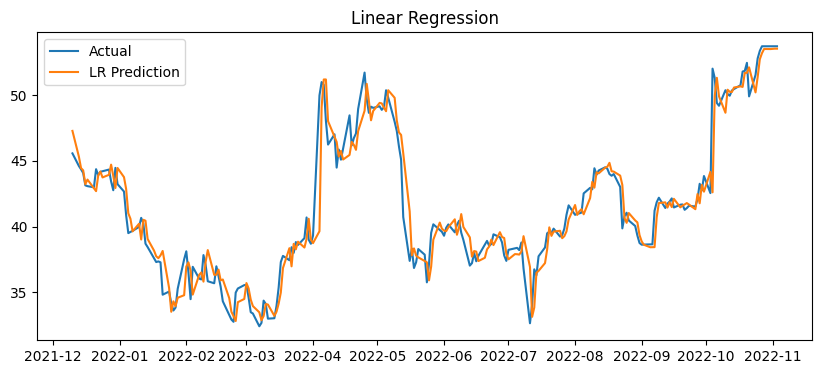

In [19]:
from sklearn.linear_model import LinearRegression

lr_model = LinearRegression().fit(X_static, y_static)
lr_preds = []
history = train.copy()

for i in range(len(test)):
    X_curr = get_features(history)
    lr_preds.append(lr_model.predict(X_curr)[0])
    history = pd.concat([history, test.iloc[[i]]])

lr_res = get_metrics(test[target], lr_preds, "Linear Regression")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, lr_preds, label='LR Prediction')
plt.legend()
plt.title("Linear Regression")

Searching for optimized Random Forest parameters...
Best RF Parameters Found: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 100}
Running Recursive Walk-Forward for Random Forest...


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with f


Optimized Random Forest Metrics:
[Random Forest (Optimized)] RMSE: 1.59, MAPE: 2.45%, R2: 0.9109


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with f

Text(0.5, 1.0, 'Random Forest')

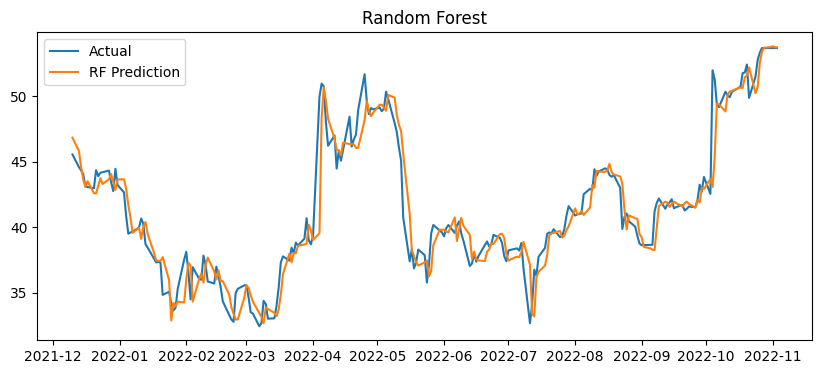

In [20]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

# 1. DEFINE PARAMETER GRID
# We tune the number of trees and the depth to control for overfitting
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 'log2']
}

# 2. TIME SERIES CROSS-VALIDATION
# Ensuring chronological validation to prevent data leakage
tscv = TimeSeriesSplit(n_splits=3)
rf_base = RandomForestRegressor(random_state=42)

print("Searching for optimized Random Forest parameters...")
rf_grid_search = GridSearchCV(
    estimator=rf_base, 
    param_grid=rf_param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

# 3. INITIAL TRAINING
# Using the static features (OHLCV + Technical Indicators) from the training set
rf_grid_search.fit(X_static, y_static)
best_rf_model = rf_grid_search.best_estimator_
print(f"Best RF Parameters Found: {rf_grid_search.best_params_}")

# 4. RECURSIVE WALK-FORWARD PREDICTION
rf_preds = []
history = train.copy()

print("Running Recursive Walk-Forward for Random Forest...")
for i in range(len(test)):
    # Calculate features for 'today' using only past data
    X_curr = get_features(history)
    
    # Predict tomorrow's Adj Close
    rf_preds.append(best_rf_model.predict(X_curr)[0])
    
    # Update history with the actual row from the test set
    actual_row = test.iloc[[i]]
    history = pd.concat([history, actual_row])

# 5. EVALUATION
print("\nOptimized Random Forest Metrics:")
rf_res = get_metrics(test[target], rf_preds, "Random Forest (Optimized)")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, rf_preds, label='RF Prediction')
plt.legend()
plt.title("Random Forest")

Searching for optimized XGBoost parameters...
Best Parameters Found: {'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.8}
Running Recursive Walk-Forward for XGBoost...
[XGBoost] RMSE: 1.55, MAPE: 2.41%, R2: 0.9157


Text(0.5, 1.0, 'XGBoost')

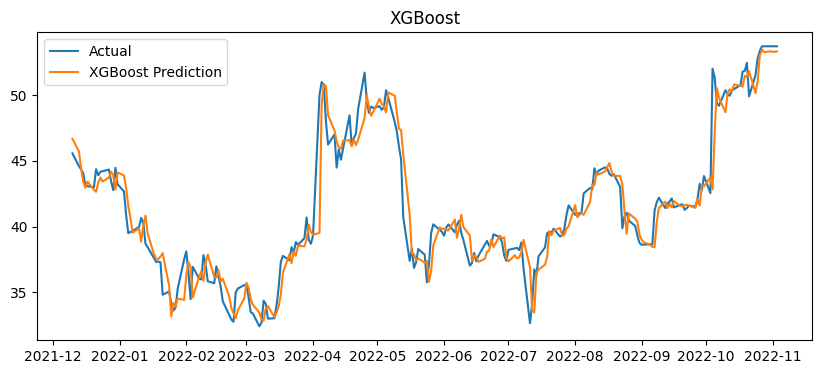

In [21]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0]
}

tscv = TimeSeriesSplit(n_splits=3)
xgb_base = XGBRegressor(objective='reg:squarederror', random_state=42)

print("Searching for optimized XGBoost parameters...")
grid_search = GridSearchCV(
    estimator=xgb_base, 
    param_grid=param_grid, 
    cv=tscv, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
)

# 3. INITIAL TRAINING
# Fit the search using the static features prepared from the 90% training data
grid_search.fit(X_static, y_static)
best_xgb_model = grid_search.best_estimator_
print(f"Best Parameters Found: {grid_search.best_params_}")

# 4. RECURSIVE WALK-FORWARD PREDICTION
# This loop recalculates features every day using only past information
xgb_preds = []
history = train.copy()

print("Running Recursive Walk-Forward for XGBoost...")
for i in range(len(test)):
    # Calculate features for 'today' based on history
    X_curr = get_features(history)
    
    # Predict tomorrow's price
    xgb_preds.append(best_xgb_model.predict(X_curr)[0])
    
    # Update history with the actual row from the test set for next day's feature calculation
    actual_row = test.iloc[[i]]
    history = pd.concat([history, actual_row])

xgb_res = get_metrics(test[target], xgb_preds, "XGBoost")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual')
plt.plot(test.index, xgb_preds, label='XGBoost Prediction')
plt.legend()
plt.title("XGBoost")

[ARIMA] RMSE: 1.46, MAPE: 2.19%, R2: 0.9247


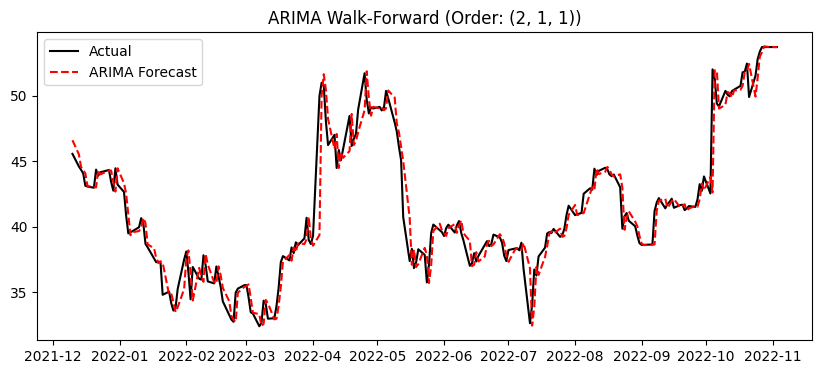

In [22]:
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA

# Find best parameters
arima_search = pm.auto_arima(train[target], seasonal=False, stepwise=True, suppress_warnings=True)
best_order = arima_search.order

arima_history = list(train[target])
arima_preds = []

for t in range(len(test)):
    model_fit = ARIMA(arima_history, order=best_order).fit()
    arima_preds.append(model_fit.forecast()[0])
    arima_history.append(test[target].iloc[t])

arima_res = get_metrics(test[target], arima_preds, "ARIMA")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target], label='Actual', color='black')
plt.plot(test.index, arima_preds, label='ARIMA Forecast', color='red', linestyle='--')
plt.title(f"ARIMA Walk-Forward (Order: {best_order})")
plt.legend()
plt.show()

Searching for optimized LSTM architecture...


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Found better model -> Units: 128, Dropout: 0.2, LR: 0.01
Found better model -> Units: 64, Dropout: 0.2, LR: 0.01
Found better model -> Units: 128, Dropout: 0.2, LR: 0.01
Finalizing training on full training set...
Running Recursive Walk-Forward for LSTM...


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
C:\Users\ADMIN\


Optimized LSTM Metrics:
[LSTM (Optimized)] RMSE: 1.57, MAPE: 2.45%, R2: 0.9136


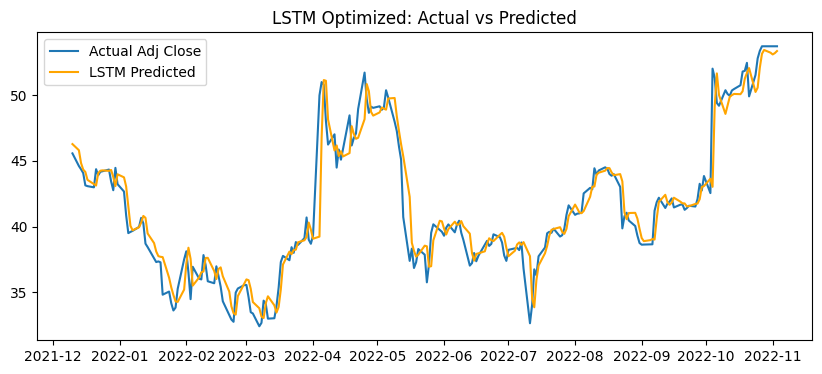

In [23]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam
import random

# 1. SCALE DATA
lstm_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = lstm_scaler.fit_transform(train[[target]])

# 2. SEQUENCE PREPARATION
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_len = 60
X_train_lstm, y_train_lstm = create_sequences(scaled_train, seq_len)

# 3. OPTIMIZATION SEARCH (Random Search)
def build_lstm(units, dropout, lr):
    model = Sequential([
        LSTM(units, return_sequences=True, input_shape=(seq_len, 1)),
        Dropout(dropout),
        LSTM(int(units/2), return_sequences=False),
        Dropout(dropout),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=lr), loss='mse')
    return model

param_grid = {'units': [32, 64, 128], 'dropout': [0.1, 0.2], 'lr': [0.001, 0.01]}
best_val_loss = float('inf')
best_lstm_model = None

print("Searching for optimized LSTM architecture...")
for _ in range(10): # Testing 3 random combinations for speed
    u, d, l = random.choice(param_grid['units']), random.choice(param_grid['dropout']), random.choice(param_grid['lr'])
    m = build_lstm(u, d, l)
    history = m.fit(X_train_lstm, y_train_lstm, validation_split=0.1, epochs=5, batch_size=32, verbose=0)
    
    val_loss = min(history.history['val_loss'])
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_lstm_model = m
        print(f"Found better model -> Units: {u}, Dropout: {d}, LR: {l}")

# 4. FINAL TRAINING
print("Finalizing training on full training set...")
best_lstm_model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=32, verbose=0)

# 5. RECURSIVE WALK-FORWARD PREDICTION
# This part ensures NO data leakage by updating the batch with actuals day-by-day
lstm_preds = []
current_batch = scaled_train[-seq_len:].reshape(1, seq_len, 1)

print("Running Recursive Walk-Forward for LSTM...")
for i in range(len(test)):
    # Predict next day based on current window
    pred_scaled = best_lstm_model.predict(current_batch, verbose=0)
    lstm_preds.append(lstm_scaler.inverse_transform(pred_scaled)[0,0])
    
    # Take actual price from test set, scale it, and slide the window
    actual_val = test[target].iloc[i]
    actual_scaled = lstm_scaler.transform([[actual_val]]).reshape(1, 1, 1)
    
    # Update current_batch: [Oldest 59 days] + [Newest actual day]
    current_batch = np.append(current_batch[:, 1:, :], actual_scaled, axis=1)

# 6. METRICS
print("\nOptimized LSTM Metrics:")
lstm_res = get_metrics(test[target], lstm_preds, "LSTM (Optimized)")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target].values, label='Actual Adj Close')
plt.plot(test.index, lstm_preds, label='LSTM Predicted', color='orange')
plt.title("LSTM Optimized: Actual vs Predicted")
plt.legend()
plt.show()

22:49:33 - cmdstanpy - INFO - Chain [1] start processing
22:49:34 - cmdstanpy - INFO - Chain [1] done processing


Running Recursive Walk-Forward for Improved Prophet...
[Prophet (Improved Recursive)] RMSE: 8.21, MAPE: 14.39%, R2: -1.3778


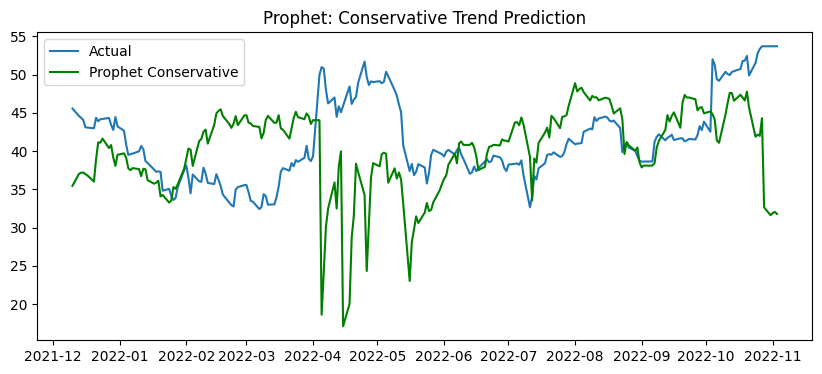

In [24]:
from prophet import Prophet

train_with_indicators = train.copy()

# Recalculate RSI for the whole training set to avoid the KeyError
delta = train_with_indicators[target].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
train_with_indicators['RSI'] = 100 - (100 / (1 + (gain/loss)))
train_with_indicators['RSI'] = train_with_indicators['RSI'].ffill().bfill()

# 2. PREPARE PROPHET HISTORY
prophet_history = train_with_indicators.reset_index()[['Date', target, 'Volume', 'RSI']].rename(
    columns={'Date': 'ds', target: 'y'}
)

# 3. CONFIGURE MODEL
m_prophet = Prophet(
    changepoint_prior_scale=0.001, 
    seasonality_mode='multiplicative',
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)
m_prophet.add_regressor('Volume')
m_prophet.add_regressor('RSI')

# 4. FIT
m_prophet.fit(prophet_history)

# 5. RECURSIVE WALK-FORWARD LOOP
prop_preds = []
current_history = train_with_indicators.copy()

print("Running Recursive Walk-Forward for Improved Prophet...")

for i in range(len(test)):
    # Create the prediction date row
    future_date = pd.DataFrame({'ds': [test.index[i]]})
    
    # Calculate features using the recursive function from earlier
    # features returns: [Open, High, Low, Volume, MA10, MA50, RSI]
    current_features = get_features(current_history) 
    
    # Map the recursive features to the Prophet regressors
    future_date['Volume'] = current_features[0, 3]
    future_date['RSI'] = current_features[0, 6]
    
    # Predict
    forecast = m_prophet.predict(future_date)
    prop_preds.append(forecast['yhat'].values[0])
    
    # Update history with the actual row for the next step
    actual_row = test.iloc[[i]].copy()
    current_history = pd.concat([current_history, actual_row], sort=False).ffill()

# 6. EVALUATION
prop_res = get_metrics(test[target], prop_preds, "Prophet (Improved Recursive)")

plt.figure(figsize=(10, 4))
plt.plot(test.index, test[target].values, label='Actual')
plt.plot(test.index, prop_preds, label='Prophet Conservative', color='green')
plt.title("Prophet: Conservative Trend Prediction")
plt.legend()
plt.show()

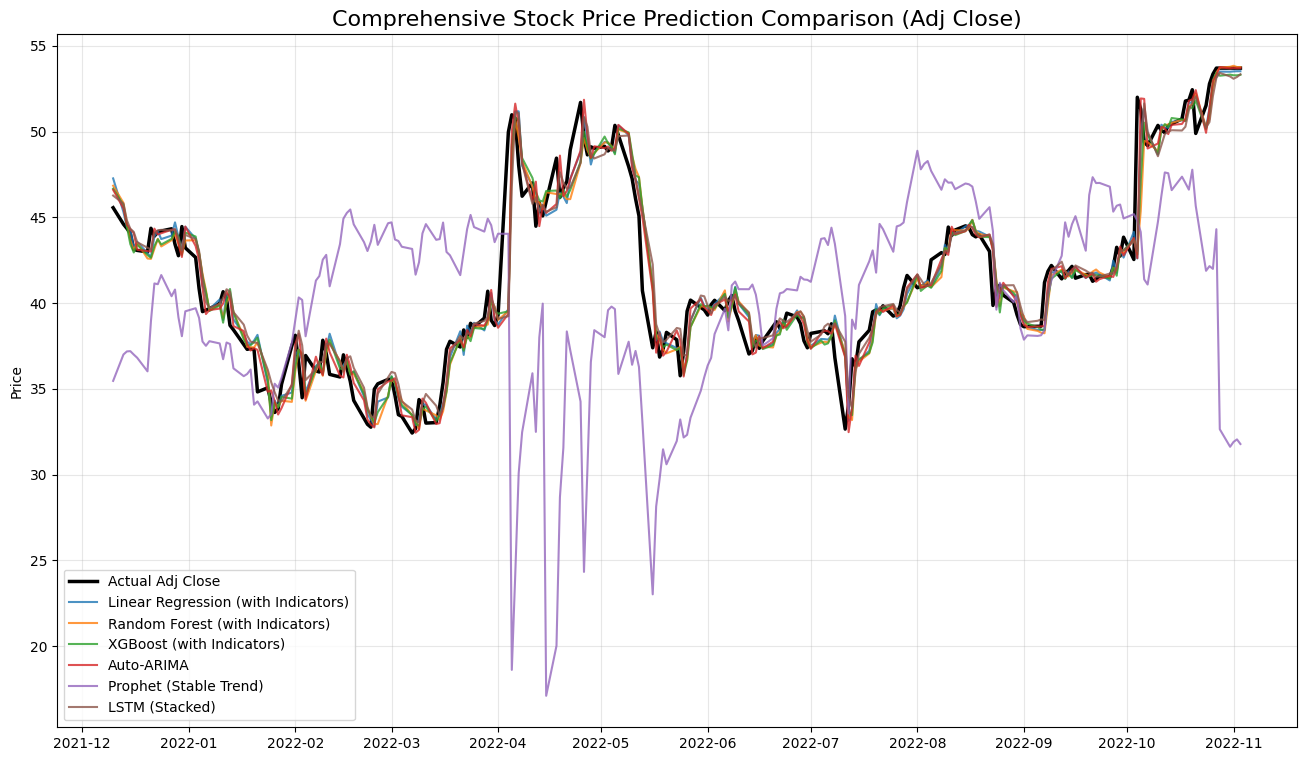

In [25]:
plt.figure(figsize=(16, 9))
plt.plot(test.index, test[target], label='Actual Adj Close', color='black', linewidth=2.5)
plt.plot(test.index, lr_preds, label='Linear Regression (with Indicators)', alpha=0.8)
plt.plot(test.index, rf_preds, label='Random Forest (with Indicators)', alpha=0.8)
plt.plot(test.index, xgb_preds, label='XGBoost (with Indicators)', alpha=0.8)
plt.plot(test.index, arima_preds, label='Auto-ARIMA', alpha=0.8)
plt.plot(test.index, prop_preds, label='Prophet (Stable Trend)', alpha=0.8)
plt.plot(test.index, lstm_preds, label='LSTM (Stacked)', alpha=0.8)

plt.title(f'Comprehensive Stock Price Prediction Comparison ({target})', fontsize=16)
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

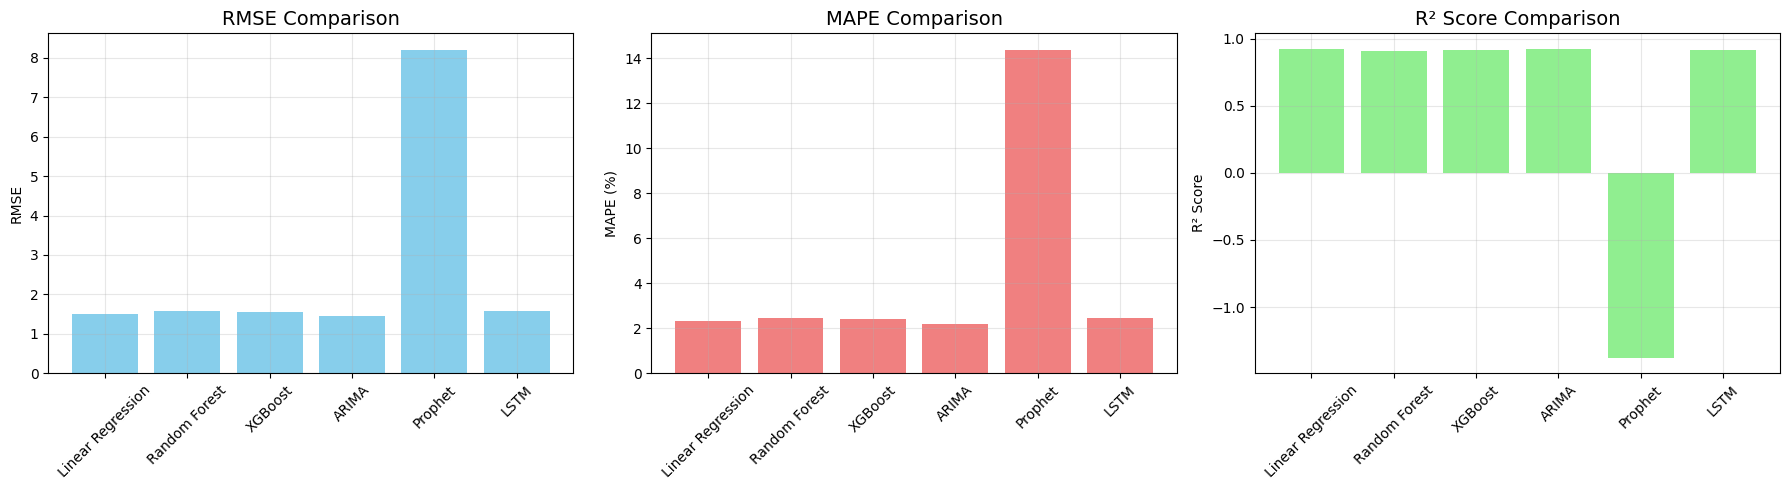

In [26]:
models = ['Linear Regression', 'Random Forest', 'XGBoost', 'ARIMA', 'Prophet', 'LSTM']
rmse_values = [lr_res[0], rf_res[0], xgb_res[0], arima_res[0], prop_res[0], lstm_res[0]]
mape_values = [lr_res[1], rf_res[1], xgb_res[1], arima_res[1], prop_res[1], lstm_res[1]]
r2_values = [lr_res[2], rf_res[2], xgb_res[2], arima_res[2], prop_res[2], lstm_res[2]]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].bar(models, rmse_values, color='skyblue')
axes[0].set_title('RMSE Comparison', fontsize=14)
axes[0].set_ylabel('RMSE')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

axes[1].bar(models, mape_values, color='lightcoral')
axes[1].set_title('MAPE Comparison', fontsize=14)
axes[1].set_ylabel('MAPE (%)')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

axes[2].bar(models, r2_values, color='lightgreen')
axes[2].set_title('R² Score Comparison', fontsize=14)
axes[2].set_ylabel('R² Score')
axes[2].tick_params(axis='x', rotation=45)
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()